# Simple Example of State Space Control
We will control a series RC circuit as shown here.

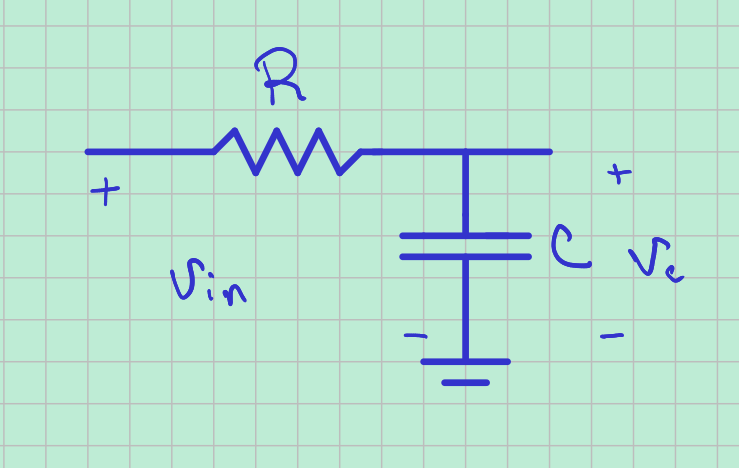 

Writing the circuit equation we have:  $$C \frac{dv_c} {dt} = \frac{v_{in}}{RC} -\frac{v_c}{RC}$$ which in state form gives us  $$\dot v_c = [-1/(RC)]v_c + [1/(RC)]v_{in}$$ and from this we see that $\mathbf A = [-1/(RC)]$, $\mathbf B = [1/(RC)]$, and $\mathbf C = 1$.  The eigenvalue of the system is $-1/(RC)$.  The input $\mathbf u = v_{in}$, and the output is taken to be the capacitor voltage.  We know analytically the capacitor voltage time response to the initial condition, is $$v_c(t) =  v_c(0) e^{-t/(RC)}$$.  We simulate that below in python.

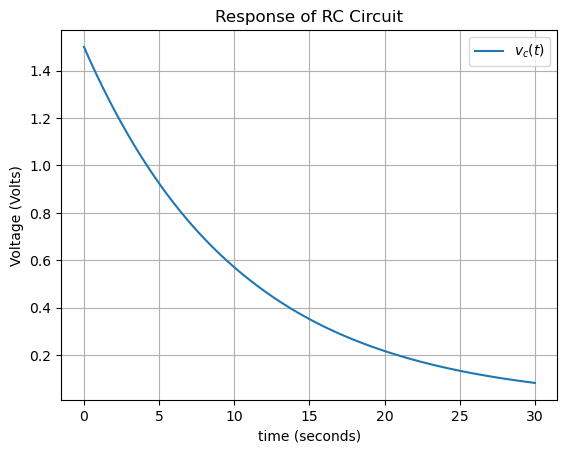

The eigenvalue is:  -0.09671179883945842
numpy gives the eigenvalue, and eigen vector respectively as: 


(array([-0.0967118]), array([[1.]]))

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import control as ctrl

R = 22e3
C = 470e-6

circuit = ctrl.ss(-1/(R*C), 1/(R*C), 1, 0)
t = np.arange(0, 30, 0.01)
u = np.zeros(len(t))
x0 = 1.5
t, vc = ctrl.input_output_response(circuit, t, u, x0)
plt.plot(t,vc)
plt.grid()
plt.title("Response of RC Circuit")
plt.legend(["$v_c(t)$"])
plt.xlabel("time (seconds)")
plt.ylabel("Voltage (Volts)")
plt.show()
print("The eigenvalue is: ",-1/(R*C))
print("numpy gives the eigenvalue, and eigen vector respectively as: ")
np.linalg.eig(circuit.A)

Suppose we want to make the response ten times as fast.  $|s\mathbf I - (\mathbf {A 
-BG}) | = 0 = s+10/(RC)$ which means $G = 2/RC$. So $$s+1/(RC) + [9/(RC)]G = s+10/(RC)$$ which simplifies to $$ 1 +G = 10$$ or $$G = 9$$ We will use the ESP32 which has an ADC and a DAC.  The ADC gives 12 bits and we will used ADC0 on pin 36. DAC1 and DAC2 are 8 bits on pin 25 and 26 respectively.  We will use one to do the control and the other as a quasi-ground, "GND" at $3.3V/2$.   The MCU will only put out and measure positive voltages, but we need to have bipolar capability for our feedback to coast back to zero output, so we will use one DAC for the driving voltage source, $v_{in}$ and another DAC to supply $3.3V/2$ to the "GND" side of our capacitor, thus raising all the voltages up by $3.3V/2$, so the MCU can have an essentially bipolar output.  We will use the 6302view software to set the sample rate and to collect and view all the variables we care about. 

Note:  It is tempting to try and use a square wave to set up the initial condition, and let it coast between the two values of the square wave.  This works for a simple RC circuit, because the DC gain is unity, however, it will not work when we apply state feedback.  With state feedback, the DC gain is a function of the amount of feedback we apply.  Because of this, we will set up the initial condition without feedback using a square wave from the MCU, and then 
let the system coast from that initial condition to our zero, "GND", the $3.3V/2$ voltage with or without feedback as desired.  Let's simulate what happens without feedback, so we know what to expect, with our real system and 6302view without feedback.

The bump at about 50 seconds is an error.  I submitted a bug report to the python control package at this URL.  https://github.com/python-control/python-control/issues/890

Now let's get python to give us the gain matrix, $\mathbf G$.

In [2]:
G = ctrl.place(circuit.A, circuit.B, -10/R/C)
print(G)

[[9.]]


### First steps:  Set up the Circuit and the software to drive the RC Circuit and Measure the Results With 6302view
We need to think about this carefully, because the DAC can only put out voltages in the range $(0,3.3)$ volts and not source more that 12mA of current.  These restrictions mean the resistance must be bigger than $3.3V/12mA = 275 \Omega$.    This is why we feed in a square wave above with an amplitude about $1.4$ volts centered on $3.3V/2$, and why we picked $R = 22k\Omega$ and $C = 470 uF$
.  The DAC voltages are set by the integers in the interval $(0, 255)$, so the scale factor for DAC number to voltage is $256/3.3$ counts per volt.

Here is the code for that drives the RC circuit with the appropriate square wave voltage:

To make this work, you build the above Arduino code for the ESP32 board, connect the RC filter to the ESP32 as shown in this photo.  The ESP32 I had handy is the 30 pin ESP32 Dev Module.  You may need to adjust the pin locations based on the ESP32 you have.  

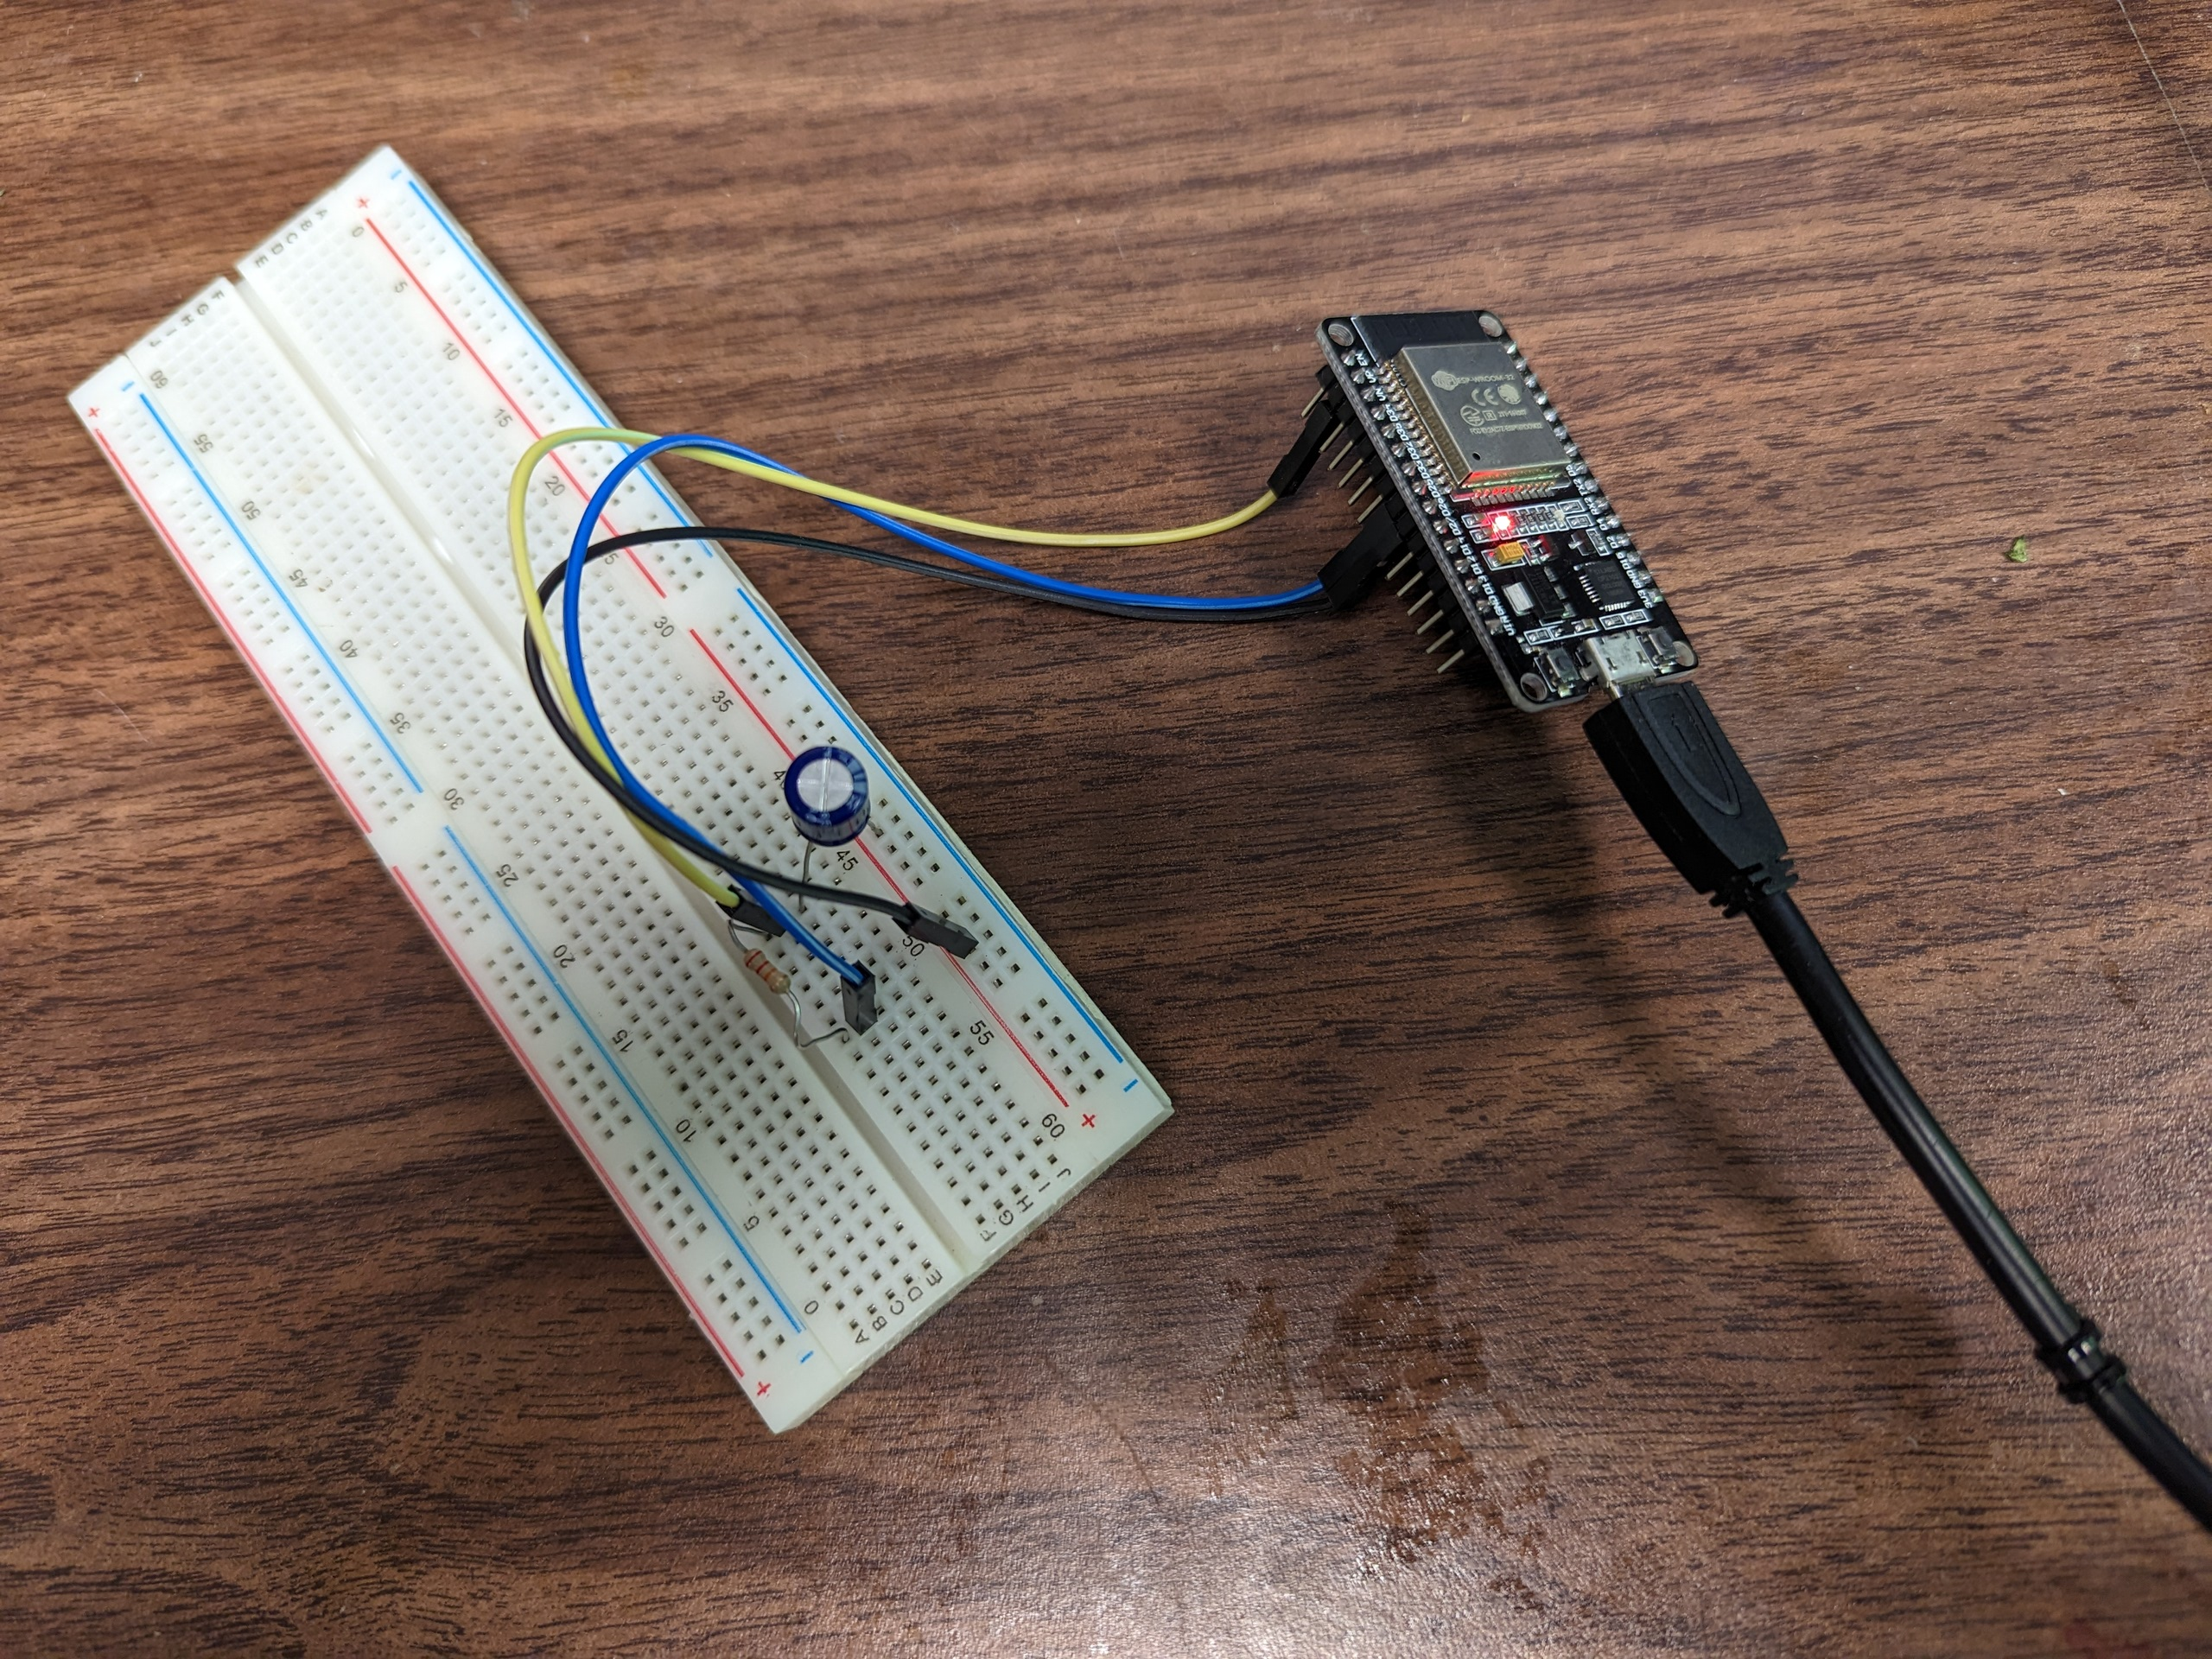

Then run the python script that acts as the webserver, as shown here.  

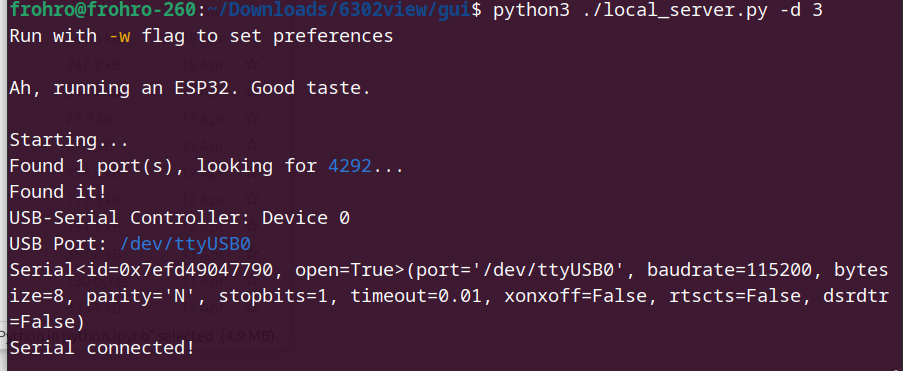 

Then open the gui.html in your browser and hit the connect button.  The results look something like this:  

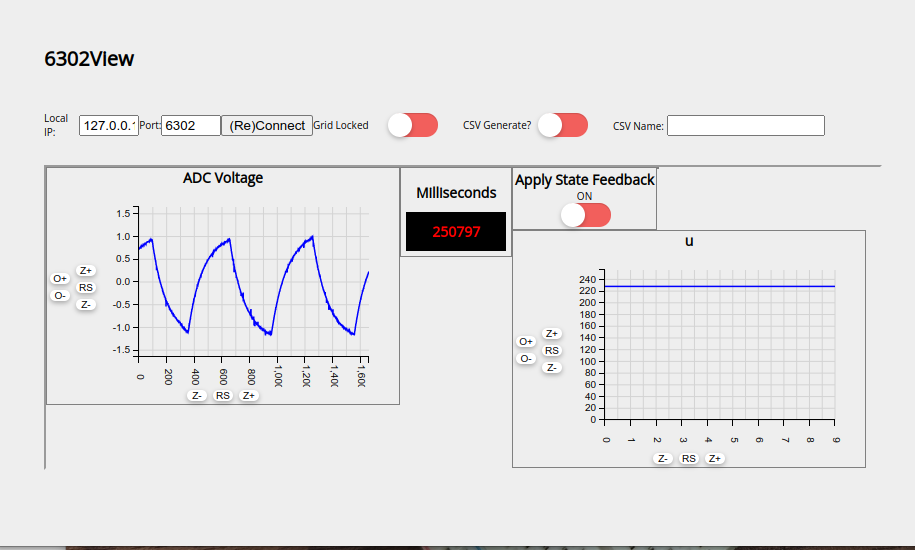 

There is a button on that webpage that allows you to save the data to a CSV file for processing outside of 6302view.  You slide the CSV File button to the right, and wait until the data you want gets collected, then slide the button back to the left, and your CSV file is then saved in the Downloads folder of your computer.

### Add State Feedback to the RC Circuit
The foregoing demonstration allows us to experimentally measure the response of our RC circuit system to a square wave input signal, and by switching the toggle, state feedback control can be added.
#### Checking to Make Sure the System is Controlable and Observable
To do this, we need measurements the state variable, and the ability to control the input to the system.  This is pretty simple with a single state system like our RC circuit, but may not be with a more complicated system.  We are doing this toy design to learn the tools, so we need to check the controllability and observability matrice's ranks.  Here is how you do that in python.

In [3]:
Q = ctrl.ctrb(circuit.A, circuit.B)
print("Q is: ", Q)
print("Rank of Q is: ", np.linalg.matrix_rank(Q))

R = ctrl.obsv(circuit.A, circuit.C)
print("R is: ", R)
print("Rank of R is: ", np.linalg.matrix_rank(R))

Q is:  [[0.0967118]]
Rank of Q is:  1
R is:  [[1.]]
Rank of R is:  1


So we see that this system is controllable and observable if we measure the capacitor voltage, $v_c$, and control the input voltage, $v_in$, which we have demonstrated how to do above.

The code above provided some nice extras.  With feedback present, we cannot easily inspect the code and be sure that the DAC is not saturated at 0V or 3.3V, so we will check the total voltage required from the DAC and display it to 6302view as $u$, and also turn on the built-in blue LED on the ESP32 if it goes higher than 3.3V or lower than 0V.  To see the effect of feedback better, we put in a slider in 6302view so we can turn on and off the feedback using 6302view.  

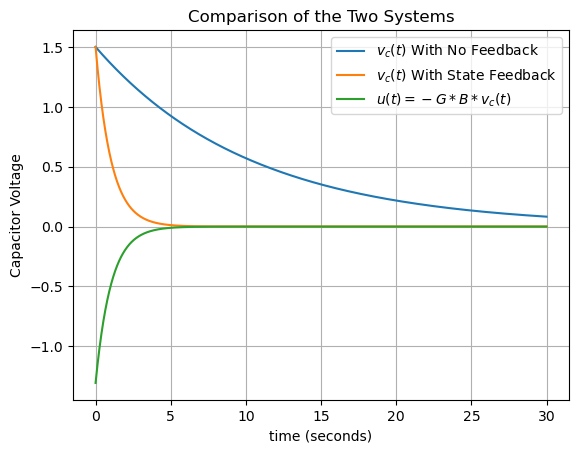

In [9]:
circuit_sfb = ctrl.ss(circuit.A-circuit.B*G, 1, 1, 0)
tfb, vcfb = ctrl.input_output_response(circuit_sfb, t, np.zeros(len(t)), x0)
plt.plot(t,vc)
plt.plot(tfb,vcfb)
u = -G*circuit.B*vcfb
plt.plot(tfb,u[0])
plt.grid()
plt.title("Comparison of the Two Systems")
plt.xlabel("time (seconds)")
plt.ylabel("Capacitor Voltage")
plt.legend(["$v_c(t)$ With No Feedback","$v_c(t)$ With State Feedback","$u(t) = -G*B*v_c(t)$"])
plt.show()

The charging curve is without feedback, and the discharging curve is with feedback.  If you look closely the discharge curve happens faster.  It changes from charge to discharge every 30 seconds.

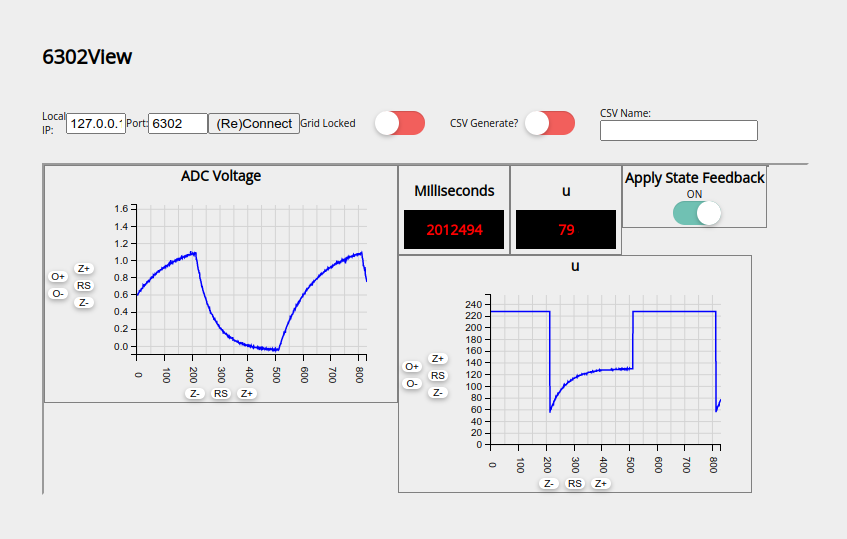


